# ESM1.6 Scaling

End-to-end pipeline generating scaling plots for ESM1.6 Pre-industrial configuration (WIP).

## Setup

This step installs packages needed - in case this wasn't done before starting the notebook.

In [ ]:
## Prerequisites

# payu/dev has experiment-generator and experiment-runner built-in, 
# but not access-parsers. Instead of trying to work with your own
# packages/venv and payu/dev module, it's easier to only work with
# the former

# install prerequisites
!pip install -r requirements.txt

  Cloning https://github.com/ACCESS-NRI/access-experiment-generator to /scratch/tm70/ey7514/tmp/pip-req-build-7jsl7xjq
  Running command git clone --filter=blob:none --quiet https://github.com/ACCESS-NRI/access-experiment-generator /scratch/tm70/ey7514/tmp/pip-req-build-7jsl7xjq
  Resolved https://github.com/ACCESS-NRI/access-experiment-generator to commit bf6da53e05fc00fd5d968cc0f893558b108f805d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


These variables control where the configurations and model run outputs are saved. Set `test_path` to somewhere where you can dump results.

In [11]:
import os
username = os.getlogin()
defaultproject = os.environ.get("PROJECT")

# CHANGE test_path to where you're comfortable dumping model run information
test_path = f"/scratch/{defaultproject}/{username}/access_models_scaling_results"
# Name of the experiment
repository_directory = "esm1.6_PI_Concentrations"

## Writing the generator config

The experiment generator config is used to control relevant parameters for generating the model output:
* number of CPUs
* layout for each of the model components (where relevant)
* walltime e.g. when using fewer resources and more walltime is needed.

Below, an example config is provided which you can modify for your needs.

In [12]:
generator_config = f"""
# Experiment Configuration File

# CHANGE these if you wish to use a different model
model_type: access-esm1.6
repository_url: git@github.com:ACCESS-NRI/access-esm1.6-configs.git
start_point: "61b5e1c"

test_path: {test_path}
repository_directory: {repository_directory}

control_branch_name: ctrl

Control_Experiment:
  config.yaml:
    walltime: 10:0:0
    modules:
      use:
        - /g/data/vk83/modules
        # tmp location for cice5 binaries
        - /g/data/tm70/ey7514/spack/0.22/release/modules/linux-rocky8-x86_64_v4
      load:
        # tmp local module
        - cice5/access-esm1.6-bkvt77m
        - access-esm1p6/2025.07.001
    # tmp workaround while local cice5 binaries are being used
    manifest:
      reproduce:
        exe: false

Perturbation_Experiment:
  Parameter_block1:
    branches:
      - 1nodes
      - 2nodes
      - 4nodes
      - 8nodes
    # processor layout for UM
    atmosphere/um_env.yaml:
      UM_ATM_NPROCX: ["4", "8", "16", "26"]
      UM_ATM_NPROCY: ["13", "13", "13", "16"]
      UM_NPES: ["52", "104", "208", "416"]
    # processor layout for CICE5
    ice/cice_in.nml:
      domain_nml:
        nprocs: [3, 6, 12, 24]
    # processor layout for MOM5
    ocean/input.nml:
      ocean_model_nml:
        layout:
          - 7, 7
          - 14, 7
          - 14, 14
          - 28, 14
    # payu config
    config.yaml:
      # this replicates what's in the original config.yaml - note the double "-".
      # second-level lists are propagated to branches e.g. ncpus: [52, 104, 208, 416] propagates
      # each ncpus value to each branch.
      submodels:
        # note the double "-"
        - - name: atmosphere
            model: um
            ncpus: [52, 104, 208, 416] # these are propagated to each branch
            exe: um_hg3.exe
            input:
                # Aerosols
              - - /g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/OCFF_1850_cmip7.anc
                - /g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/BC_1850_cmip7.anc
                - /g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/scycl_1850_cmip7.anc
                - /g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/Bio_1850_cmip7.anc
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/aerosol/global.N96/2020.05.19/biogenic_351sm.N96L38
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/aerosol/global.N96/2020.05.19/sulpc_oxidants_N96_L38
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/aerosol/global.N96/2020.05.19/DMS_conc.N96
                # Forcing
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/pre-industrial/atmosphere/forcing/global.N96/2020.05.19/ozone_1850_ESM1.anc
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/pre-industrial/atmosphere/forcing/resolution_independent/2020.05.19/volcts_18502000ave.dat
                # Land
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/pre-industrial/atmosphere/land/biogeochemistry/global.N96/2020.05.19/Ndep_1850_ESM1.anc
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/land/soiltype/global.N96/2020.05.19/qrparm.soil_igbp_vg
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/land/vegetation/global.N96/2020.05.19/cable_vegfunc_N96.anc
                - /g/data/vk83/prerelease/configurations/inputs/access-esm1p6/share/atmosphere/land/biogeochemistry/resolution_independent/2025.06.06/modis_phenology_csiro_nophase.txt
                - /g/data/vk83/prerelease/configurations/inputs/access-esm1p6/share/atmosphere/land/biogeochemistry/resolution_independent/2024.12.18/pftlookup_cable3.csv
                - /g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/land/biogeophysics/resolution_independent/2020.05.19/def_soil_params.txt
                - /g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/land/biogeophysics/resolution_independent/2020.05.19/def_veg_params.txt
                # Spectral
                - /g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/spectral/resolution_independent/2020.05.19/spec3a_sw_hadgem1_6on
                - /g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/spectral/resolution_independent/2020.05.19/spec3a_lw_hadgem1_6on
                # Grids
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/grids/global.N96/2020.05.19/qrparm.mask
                - /g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/grids/resolution_independent/2020.05.19/vertlevs_G3
                # STASH
                - /g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/stash/2020.05.19/

          - name: ocean
            model: mom
            ncpus: [49, 98, 196, 392]
            exe: mom5_access_cm 
            input:
                # Biogeochemistry
              - - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/biogeochemistry/global.1deg/2020.05.19/dust.nc
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/biogeochemistry/global.1deg/2020.05.19/ocmip2_press_monthly_om1p5_bc.nc
                # Tides
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/tides/global.1deg/2020.05.19/roughness_amp.nc
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/tides/global.1deg/2020.05.19/tideamp.nc
                # Shortwave
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/shortwave_penetration/global.1deg/2025.06.23/ssw_atten_depth.nc
                # Grids
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/mosaic/global.1deg/2025.07.29/grid_spec.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/mosaic/global.1deg/2025.07.29/ocean_mosaic.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/mosaic/global.1deg/2025.07.29/ocean_hgrid.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/bathymetry/global.1deg/2025.07.29/topog.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/vertical/global.1deg/2025.07.29/ocean_vgrid.nc

          - name: ice
            model: cice5
            ncpus: [3, 6, 12, 24]
            exe: 
              - cice_access-esm1.6_360x300_3x1_3p.exe
              - cice_access-esm1.6_360x300_6x1_6p.exe
              - cice_access-esm1.6_360x300_12x1_12p.exe
              - cice_access-esm1.6_360x300_24x1_24p.exe
            input:
                # Grids
              - - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ice/grids/global.1deg/2025.07.29/kmt.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ice/grids/global.1deg/2025.07.29/grid.nc
                # Iceberg flux
                - /g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/share/ice/iceberg/global.1deg/2024.11.08/lice_discharge_iceberg.nc
          - name: coupler
            model: oasis
            ncpus: 0
            input:
                # Grids
              - - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/grids/global.oi_1deg.a_N96/2025.07.29/grids.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/grids/global.oi_1deg.a_N96/2025.07.29/areas.nc
                - /g/data/vk83/configurations/inputs/access-esm1p5/modern/share/coupler/grids/global.oi_1deg.a_N96/2020.05.19/masks.nc
                # Remapping weights
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_cice_to_um1t_CONSERV_FRACNNEI.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_cice_to_um1u_CONSERV_FRACNNEI.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_cice_to_um1v_CONSERV_FRACNNEI.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1t_to_cice_CONSERV_DESTAREA.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1t_to_cice_CONSERV_FRACNNEI.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1u_to_cice_CONSERV_FRACNNEI.nc
                - /g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1v_to_cice_CONSERV_FRACNNEI.nc

"""

In [ ]:
# writing the config
with open("esm1.6.yaml", 'w') as f:
    f.write(generator_config)

## Running models AKA generating scaling data

This uses the experiment generator CLI utility with the previously written config.

`experiment-generator`, using the config will:

1. clone the branch into test_path/repository_directory path specified in the config.
2. create a control branch from the changes specified in `Control_Experiment` from the config.
3. create the experiment branches from the `Perturbation_Experiment` parameter blocks.

If the branches already exist, then only the differences are applied.

In [14]:
!experiment-generator -i esm1.6.yaml

-- Test directory /scratch/tm70/ey7514/access_models_scaling_results already exists!
-- Test dir: /scratch/tm70/ey7514/access_models_scaling_results/esm1.6_PI_Concentrations already exists, hence not cloning git@github.com:ACCESS-NRI/access-esm1.6-configs.git
Checked out branch: ctrl
laboratory path:  /scratch/tm70/ey7514/access-esm
binary path:  /scratch/tm70/ey7514/access-esm/bin
input path:  /scratch/tm70/ey7514/access-esm/input
work path:  /scratch/tm70/ey7514/access-esm/work
archive path:  /scratch/tm70/ey7514/access-esm/archive
Found experiment archive: /scratch/tm70/ey7514/access-esm/archive/esm1.6_PI_Concentrations-ctrl-ad67a907
Removed archive symlink to /scratch/tm70/ey7514/access-esm/archive/esm1.6_PI_Concentrations-8nodes-11cf43a7
Added archive symlink to /scratch/tm70/ey7514/access-esm/archive/esm1.6_PI_Concentrations-ctrl-ad67a907
-- Branch 1nodes already exists, switching to it only!
Checked out branch: 1nodes
laboratory path:  /scratch/tm70/ey7514/access-esm
binary path

Now that the experiment configs have been generated, create a runner config and run the experiment with `experiment-runner` CLI utility.

In [15]:
# generate runner config. It's relatively simple, so writing the config here.
with open("runner.yaml", 'w') as f:
    f.write(f"""
test_path: {test_path}
repository_directory: {repository_directory}
# these branches need to match branches in the experiment generator config above.
running_branches: 
    - 1nodes
    - 2nodes
    - 4nodes
    - 8nodes 
keep_uuid: True

# currently nruns != 1 doesn't work.
nruns: [1, 1, 1, 1]
startfrom_restart: [cold, cold, cold, cold]
""")

# use the runner config with experiment-runner
!experiment-runner -i runner.yaml

* Current Branch: 8nodes
    experiment_uuid: 11cf43a7-40f0-446a-8662-dfe82c19e0c7
Branch: 1nodes
    experiment_uuid: bb06ce4e-5b5a-4b37-b709-3d5060c94b3a
Branch: 2nodes
    experiment_uuid: 95e7f3cb-19a3-497d-bc1d-2bcc267574e0
Branch: 4nodes
    experiment_uuid: e1144a03-381d-4f4c-acd9-12498e123eb7
Branch: ctrl
    experiment_uuid: ad67a907-8fc6-46cd-b2bf-288d6693f42c
Branch: main
    No config file found
-- Cloning branch '1nodes' into /scratch/tm70/ey7514/access_models_scaling_results/1nodes/esm1.6_PI_Concentrations...
Cloned repository from /scratch/tm70/ey7514/access_models_scaling_results/esm1.6_PI_Concentrations to directory: /scratch/tm70/ey7514/access_models_scaling_results/1nodes/esm1.6_PI_Concentrations
Checked out branch: 1nodes
laboratory path:  /scratch/tm70/ey7514/access-esm
binary path:  /scratch/tm70/ey7514/access-esm/bin
input path:  /scratch/tm70/ey7514/access-esm/input
work path:  /scratch/tm70/ey7514/access-esm/work
archive path:  /scratch/tm70/ey7514/access-esm/a

After running the experiment, you should have:
* a directory containing branches for each experiment
* a directory for each experiment result
    * the results will be in corresponding 'archive' directories

In [16]:
# you should have:
# * a directory containing branches for each expeiriment
!tree -dL 3 {test_path}

/scratch/tm70/ey7514/access_models_scaling_results
├── 1nodes
│   └── esm1.6_PI_Concentrations
│       ├── archive -> /scratch/tm70/ey7514/access-esm/archive/esm1.6_PI_Concentrations-1nodes-bb06ce4e
│       ├── atmosphere
│       ├── coupler
│       ├── ice
│       ├── manifests
│       ├── ocean
│       ├── scripts
│       └── testing
├── 2nodes
│   └── esm1.6_PI_Concentrations
│       ├── archive -> /scratch/tm70/ey7514/access-esm/archive/esm1.6_PI_Concentrations-2nodes-95e7f3cb
│       ├── atmosphere
│       ├── coupler
│       ├── ice
│       ├── manifests
│       ├── ocean
│       ├── scripts
│       └── testing
├── 4nodes
│   └── esm1.6_PI_Concentrations
│       ├── archive -> /scratch/tm70/ey7514/access-esm/archive/esm1.6_PI_Concentrations-4nodes-e1144a03
│       ├── atmosphere
│       ├── coupler
│       ├── ice
│       ├── manifests
│       ├── ocean
│       ├── scripts
│       └── testing
├── 8nodes
│   └── esm1.6_PI_Concentrations
│       ├── archive -> /scratch/tm70/ey7514/

## Parsing experiment results

We'll use the profiling parsers in access-parsers to do this.

In [5]:
# Draft post-processing functions (these would be put into some sort of module)

from typing import List
from collections.abc import Iterable
from access.parsers.profiling import ProfilingParser
import xarray as xr


def parse_profiling_data(
    logs: List[str], parser: ProfilingParser, varname: str, vars: Iterable
):

    datasets = []
    for var, log in zip(vars, logs):
        data = parser.read(log)
        datasets.append(
            xr.Dataset(
                data_vars=dict(
                    zip(
                        parser.metrics,
                        [
                            xr.DataArray([data[metric]], dims=[varname, "region"])
                            for metric in parser.metrics
                        ],
                    )
                ),
                coords={"region": data["region"], varname: [var]},
            )
        )
    return xr.concat(datasets, dim=varname)


def scaling_speedup(stats: xr.Dataset, metric: str = "tavg") -> xr.Dataset:
    """Calculates the parallel speedup from scaling data.

    Args:
        stats (Dataset): Scaling data, stored as a xarray dataset.

    Returns:
        Dataset: Parallel speedup.
    """
    speedup = stats[metric].sel(ncpus=stats["ncpus"].min()) / stats[metric]
    speedup.name = "speedup"
    return speedup


def scaling_efficiency(stats: xr.Dataset, metric: str = "tavg") -> xr.Dataset:
    """Calculates the parallel efficiency from scaling data.

    Args:
        stats (Dataset): Scaling data, stored as a xarray dataset.

    Returns:
        Dataset: Parallel efficiency.
    """
    speedup = scaling_speedup(stats, metric)
    eff = speedup / speedup.ncpus * 100 * stats["ncpus"].min()
    eff.name = "parallel efficiency [%]"
    return eff

In [6]:
# plotting functions. Might want to keep these in the notebook so they're modifiable by the user?

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def calculate_column_widths(table_data, first_col_flexible=True):
    """
    Calculate column widths based on content length

    Args:
        table_data (List[list]): Table data including headers
        first_col_flexible (bool): If True, first column gets remaining space after others are sized

    Returns:
        list : Column width ratios
    """
    if not table_data:
        return []

    n_cols = len(table_data[0])

    # Calculate max content length for each column
    max_lengths = []
    for col in range(n_cols):
        col_lengths = [len(str(row[col])) for row in table_data]
        max_lengths.append(max(col_lengths))

    if first_col_flexible:
        # Set data columns to proportional widths based on content
        # Give first column remaining space
        data_cols_total = sum(max_lengths[1:])
        base_width = 0.6 / data_cols_total if data_cols_total > 0 else 0.1

        col_widths = [0.4]  # First column gets 40% of space
        for length in max_lengths[1:]:
            col_widths.append(length * base_width)

        # Adjust to sum to 1.0
        current_sum = sum(col_widths)
        col_widths = [w / current_sum for w in col_widths]

        # Give first column any remaining space
        remaining = 1.0 - sum(col_widths[1:])
        col_widths[0] = remaining
    else:
        # Proportional to content length
        total_length = sum(max_lengths)
        col_widths = [length / total_length for length in max_lengths]

    return col_widths


def plot_regions(
    stats: List[xr.Dataset],
    regions: List[List[str]],
    metrics: List[str],
    xcoordinate: str = "ncpus",
):
    """Plots scaling speedup and efficiency from a list of datasets

    Args:
        stats (List[xr.Dataset]): The raw times to plot.
        regions (List[List[str]]): The list of regions to plot.
            regions[0][:] corresponds to regions to plot in stats[0].
        metrics (List[str]): The metrics to plot for each stat.
        xcoordinate (str): The x-axis variable e.g. ncpus.
    """
    # setup plots
    fig = plt.figure(figsize=(15, 6))
    # using gridspec so table can be added
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace=0.3)
    ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
    ax_tbl = fig.add_subplot(gs[1, :])

    # add table of raw timings
    tbl = [[xcoordinate] + list(stats[0][xcoordinate].values)]  # first row
    for stat, region, metric in zip(stats, regions, metrics):

        # calculate efficiency and speedup
        efficiency = scaling_efficiency(stat, metric)
        speedup = scaling_speedup(stat, metric)

        # plots speedup and efficiency on their respective axes.
        max_eff = 100
        for r in region:
            speedup.loc[r, :].plot.line(x=xcoordinate, ax=ax1, marker="o", label=r)
            efficiency.loc[r, :].plot.line(x=xcoordinate, ax=ax2, marker="o", label=r)
            # find max efficiency for setting efficiency axis
            max_eff = max(max_eff, efficiency.loc[r, :].max())

        tbl.append([region] + [f"{val:.2f}" for val in stat[metric].loc[:, r].values])

    # ideal speedup/scaling
    minx = stat[xcoordinate].values.min()
    nx = len(stat[xcoordinate].values)
    ideal_speedups = [i / minx for i in stat[xcoordinate].values]
    ax1.plot(stat[xcoordinate].values, ideal_speedups, "k:", label="ideal")
    ax2.plot(stat[xcoordinate].values, [100] * nx, "k:", label="ideal")

    # formatting
    ax1.legend()
    ax1.grid()
    ax2.grid()
    ax2.set_ylim((0, 1.1 * max_eff))
    ax1.set_title("Scaling Speedup")
    ax2.set_title("Scaling Efficiency")
    ax_tbl.axis("off")
    tbl_chart = ax_tbl.table(
        tbl,
        bbox=(0.05, 0, 0.9, 1),
        cellLoc="center",
        colWidths=calculate_column_widths(tbl),
    )
    ax_tbl.set_title("Timings (s)")
    for i in range(len(tbl[0])):
        tbl_chart[(0, i)].set_text_props(weight="bold")
    for i in range(len(tbl)):
        tbl_chart[(i, 0)].set_text_props(weight="bold")

In [7]:
# Start by processing FMS (MOM5) results
from access.parsers.fms_profiling import FMSProfilingParser
from access.parsers.payujson_profiling import PayuJSONProfilingParser
fmsparser = FMSProfilingParser(has_hits=False)
payuparser = PayuJSONProfilingParser()

In [8]:
# Processing logs
from pathlib import Path
import glob

fmslogs = []
payulogs = []
for nnodes in (1, 2, 4, 8):
    archive_dir = f"esm1.6-scaling/{nnodes}nodes/PI_concentrations/archive"
    with open(archive_dir + "/output000/access-esm1.6.out", "r") as f:
        fmslogs.append(f.read())
    payulog = glob.glob(archive_dir + "/payu_jobs/0/run/*.gadi-pbs.json")[0]
    with open(payulog, "r") as f:
        payulogs.append(f.read())

In [9]:
fmsstats = parse_profiling_data(
    fmslogs,
    fmsparser,
    "ncpus",
    [104, 208, 416, 832]
)
fmsstats

<xarray.Dataset> Size: 70kB
Dimensions:  (ncpus: 4, region: 183)
Coordinates:
  * region   (region) <U32 23kB 'Total runtime' 'Ocean' ... 'oasis_send'
  * ncpus    (ncpus) int64 32B 104 208 416 832
Data variables:
    tmin     (ncpus, region) float64 6kB 1.628e+04 1.597e+04 ... 0.9289
    tmax     (ncpus, region) float64 6kB 1.628e+04 1.6e+04 ... 4.128e+03 1.445
    tavg     (ncpus, region) float64 6kB 1.628e+04 1.599e+04 ... 4.06e+03 1.092
    tstd     (ncpus, region) float64 6kB 1e-06 8.644 0.00147 ... 25.68 0.1059
    tfrac    (ncpus, region) float64 6kB 1.0 0.982 0.0 0.0 ... 0.0 0.0 0.601 0.0
    grain    (ncpus, region) int64 6kB 0 1 11 11 31 31 31 ... 31 41 41 1 1 31 31
    pemin    (ncpus, region) int64 6kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    pemax    (ncpus, region) int64 6kB 48 48 48 48 48 48 ... 391 391 391 391 391

In [10]:
# first 10 regions
fmsstats.region[:10]

<xarray.DataArray 'region' (region: 10)> Size: 1kB
array(['Total runtime', 'Ocean', '(Ocean initialization)', '(Ocean ODA)',
       '(Red Sea/Gulf Bay salinity fix)', '(Ocean advection velocity)',
       '(Ocean density diag)', '(Ocean update density)',
       '(Ocean vertical mixing coeff)', '(Ocean neutral physics)'],
      dtype='<U32')
Coordinates:
  * region   (region) <U32 1kB 'Total runtime' ... '(Ocean neutral physics)'

In [11]:
payustats = parse_profiling_data(
    payulogs,
    payuparser,
    "ncpus",
    [104, 208, 416, 832]
)
payustats.region

<xarray.DataArray 'region' (region: 5)> Size: 620B
array(['payu_setup_duration_seconds', 'payu_model_run_duration_seconds',
       'payu_run_duration_seconds', 'payu_archive_duration_seconds',
       'payu_total_duration_seconds'], dtype='<U31')
Coordinates:
  * region   (region) <U31 620B 'payu_setup_duration_seconds' ... 'payu_total...

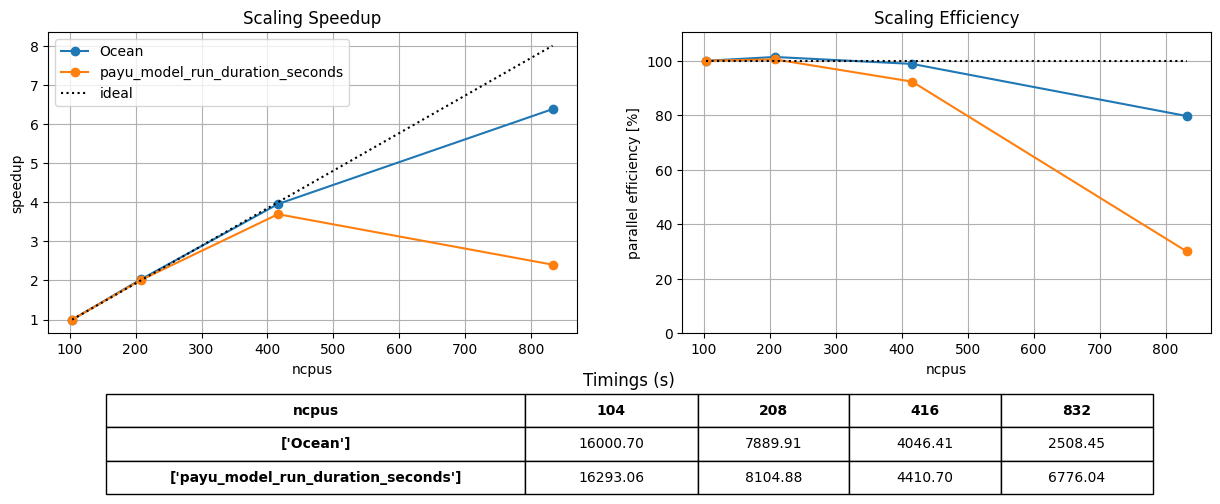

In [12]:
# plots the Ocean region and tmax metric from the FMS stats, and 
# payu_model_run_duration_seconds region and walltime metric from payu stats.
plot_regions(
    stats=[fmsstats, payustats], 
    regions=[
        ["Ocean"], 
        ["payu_model_run_duration_seconds"]
    ], 
    metrics=["tmax", "walltime"]
)